In [1]:
import datetime, zarr, dask, rasterio as rio, rioxarray as rxr, pandas as pd, rasterstats, tqdm, pathlib, geopandas as gpd, matplotlib.pyplot as plt
from scipy.stats import uniform, norm, multivariate_normal, truncnorm
import plotnine as pn
import os
import subprocess
import importlib
import pyDOE2

<h5>Download Data</h5>

In [2]:
#Download data from AWS
#1. In terminal - 
    # curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    # unzip awscliv2.zip
    # sudo ./aws/install
#3. In terminal inside docker type - aws configure
#4. Add key provided by admin and set region to us-west-2 and output format to json

#Duwamish S3 URL for tif files 
s3_url = "s3://importance-sampling-sst/Duwamish/"
local_dir = "/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish"
os.makedirs(local_dir)
subprocess.run(["aws","s3","cp",s3_url,local_dir,"--recursive"], check = True)

download: s3://importance-sampling-sst/Duwamish/catalog/tifs/19791018_T229.tif to ../data/0_source/Duwamish/catalog/tifs/19791018_T229.tif
download: s3://importance-sampling-sst/Duwamish/catalog/tifs/19800108_T245.tif to ../data/0_source/Duwamish/catalog/tifs/19800108_T245.tif
download: s3://importance-sampling-sst/Duwamish/catalog/tifs/19790211_T411.tif to ../data/0_source/Duwamish/catalog/tifs/19790211_T411.tif
download: s3://importance-sampling-sst/Duwamish/catalog/tifs/19791212_T021.tif to ../data/0_source/Duwamish/catalog/tifs/19791212_T021.tif
download: s3://importance-sampling-sst/Duwamish/catalog/tifs/19791217_T029.tif to ../data/0_source/Duwamish/catalog/tifs/19791217_T029.tif
download: s3://importance-sampling-sst/Duwamish/catalog/tifs/19800112_T043.tif to ../data/0_source/Duwamish/catalog/tifs/19800112_T043.tif
download: s3://importance-sampling-sst/Duwamish/catalog/tifs/19790205_T163.tif to ../data/0_source/Duwamish/catalog/tifs/19790205_T163.tif
download: s3://importance-s

CompletedProcess(args=['aws', 's3', 'cp', 's3://importance-sampling-sst/Duwamish/', '/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish', '--recursive'], returncode=0)

In [13]:
#Load Importance sampling functions
import sys
sys.path.append('../src')

from utils import match_crs_to_raster, get_sp_stats, get_files_pathlib, truncnorm_params
from transpose import sample_storms

In [4]:
#Locate data
path_sp_watershed = "/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/geojson/duwamish.geojson"
path_sp_domain = "/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/geojson/duwamish-transpo-area-v01.geojson"

path_storm = pathlib.Path('/workspaces/Importance-Sampling-for-SST/data/0_source/Duwamish/catalog')
df_storms = pd.read_pickle(path_storm/'catalog.pkl')

In [5]:
#Load shapefiles and match projection with rasters
sp_watershed = gpd.read_file(path_sp_watershed)
sp_watershed = match_crs_to_raster(sp_watershed, df_storms['path'].iloc[0])

sp_domain = gpd.read_file(path_sp_domain)
sp_domain = match_crs_to_raster(sp_domain, df_storms['path'].iloc[0])

Reprojecting polygon from EPSG:4326 to EPSG:5070...
Reprojecting polygon from EPSG:4326 to EPSG:5070...


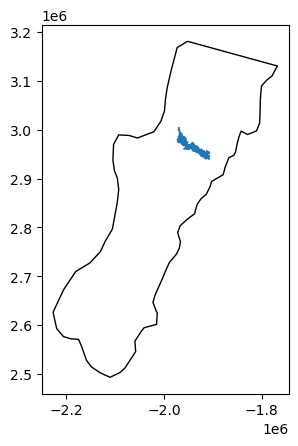

In [6]:
sp_watershed.plot()
sp_domain.plot(ax=plt.gca(),facecolor="none")
plt.show()

In [9]:
v_watershed_stats = get_sp_stats(sp_watershed)
v_domain_stats = get_sp_stats(sp_domain)
print(v_watershed_stats, v_domain_stats)

minx       -1.974568e+06
miny        2.938089e+06
maxx       -1.905108e+06
maxy        3.005395e+06
x          -1.942311e+06
y           2.965859e+06
range_x     6.946011e+04
range_y     6.730658e+04
area_km2    2.732960e+03
Name: 0, dtype: float64 minx       -2.226803e+06
miny        2.493512e+06
maxx       -1.768135e+06
maxy        3.180672e+06
x          -2.008039e+06
y           2.857018e+06
range_x     4.586682e+05
range_y     6.871599e+05
area_km2    2.486725e+05
Name: 0, dtype: float64


In [12]:
dist_x = truncnorm(**truncnorm_params(v_watershed_stats.x, v_watershed_stats.range_x*1, v_domain_stats.minx, v_domain_stats.maxx))
dist_y = truncnorm(**truncnorm_params(v_watershed_stats.y, v_watershed_stats.range_y*1, v_domain_stats.miny, v_domain_stats.maxy))

In [14]:
n_sim_mc_0 = 100000
n_sim_is_1 = 10000
df_storm_sample_mc_0 = sample_storms(df_storms, v_domain_stats, dist_x=None, dist_y=None, num_simulations=n_sim_mc_0)
df_storm_sample_mc_1 = sample_storms(df_storms, v_domain_stats, dist_x=None, dist_y=None, num_simulations=n_sim_is_1)
df_storm_sample_is_1 = sample_storms(df_storms, v_domain_stats, dist_x, dist_y, num_simulations=n_sim_is_1)

100%|██████████| 10000/10000 [00:03<00:00, 2545.86it/s]


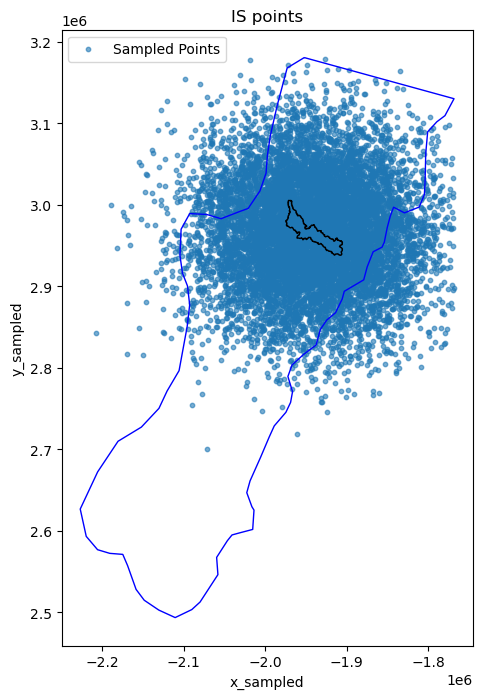

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
df_storm_sample_is_1.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("IS points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()